# Name: Phil Clarke
    
# Student ID: 23291567

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, explained_variance_score, mean_squared_log_error, mean_absolute_percentage_error, max_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors 
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.feature_selection import f_regression
from sklearn.neighbors import KNeighborsRegressor

# Section 2a  Importing Data

In [2]:
df = pd.read_csv("./insurance.csv")
df.dtypes

age                 int64
gender             object
bmi               float64
children            int64
smoker             object
region             object
insurance_cost    float64
dtype: object

# Section 2b  EDA on Insurance Cost Data

In [3]:
df.isna().sum()  #Checking for missing values - None

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [4]:
df.describe()  #looking at numerical values - no major outlier problem

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

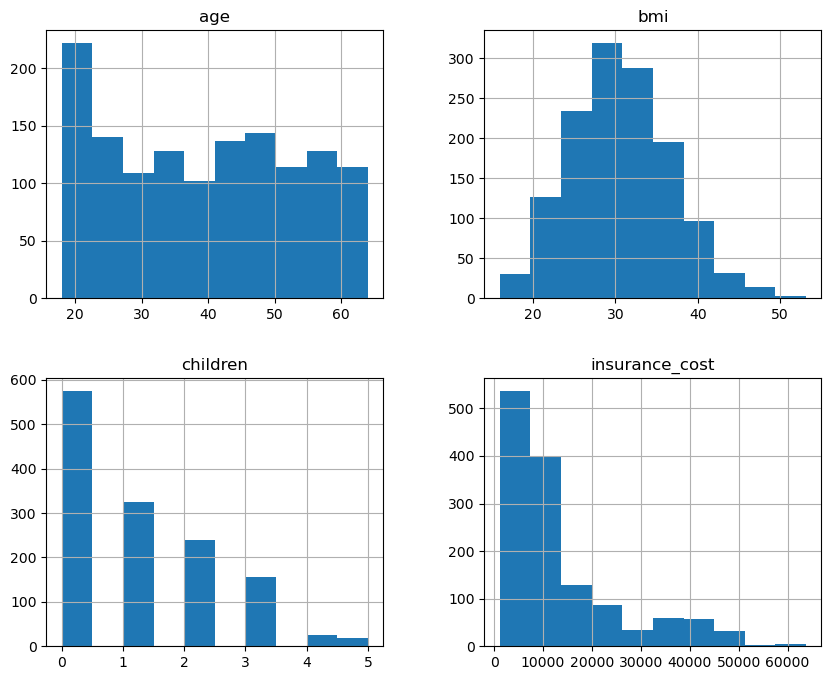

C:\Users\filcl\AppData\Local\Temp\ipykernel_9336\4205394896.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()  # Correlation matrix of the numeric varibles - highest correlation values were BMI and Age.


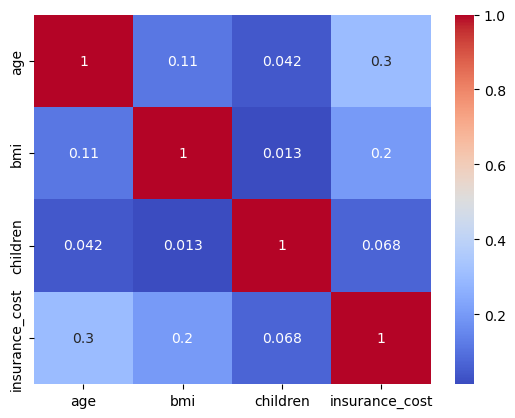

In [5]:
df.hist(figsize=(10, 8))  #Histogram of the numerical values above - data appears to be either uniformally or normally distributed
#age appears to be over represented at the younger age but no gaps in data
#very marginal skewing on bmi
plt.show()
corr_matrix = df.corr()  # Correlation matrix of the numeric varibles - highest correlation values were BMI and Age.
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()



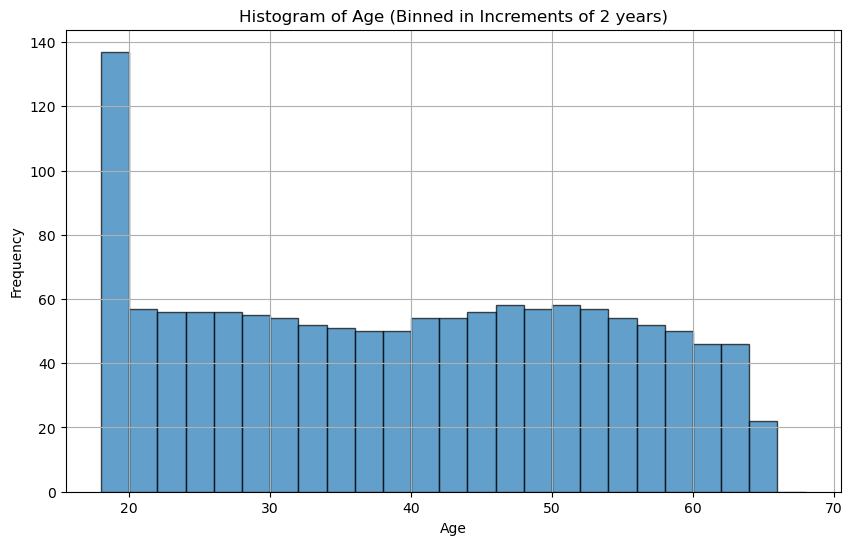

In [6]:
#Zooming in on age - twice the representation in the youngest, should not affect modelling
bin_range = range(df['age'].min(), df['age'].max() + 6, 2)

plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=bin_range, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age (Binned in Increments of 2 years)')
plt.grid(True)
plt.show()

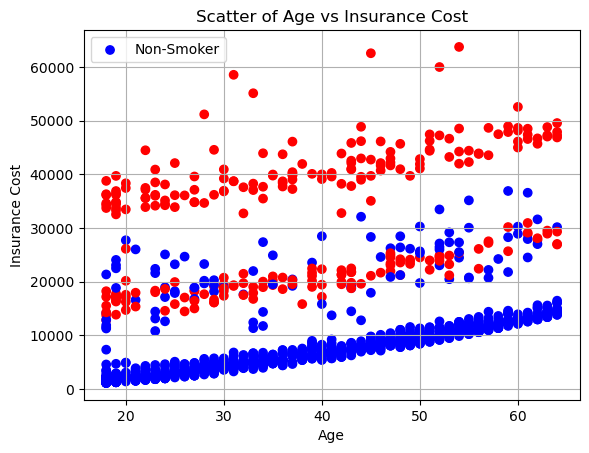

In [7]:
#so it looks like there is a linear relationship with age and insurance cost with steps occurring in the event of smoking or other factors (like high BMI)
df['smoker_code'] = df['smoker'].map({'no': 0, 'yes': 1})
colors = ['blue', 'red'] #colours for legend

plt.scatter(df['age'], df['insurance_cost'], c=df['smoker_code'], cmap=matplotlib.colors.ListedColormap(colors))

plt.xlabel('Age')
plt.ylabel('Insurance Cost')
plt.title('Scatter of Age vs Insurance Cost')

plt.grid(True)
plt.legend(['Non-Smoker'], loc='upper left')
plt.show()

#The skewness in the insurance cost, we will transformed in the target regressor

# Section 2c Splitting Data to X and y

In [8]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

# Section 2d Transformers

In this section I set up my transformers that will be part of the data pipeline.  From the EDA I believe the appropriate transforms are:

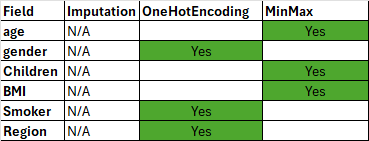


Which will give me two sets of transforms, one on the numerical and one on the categorical varibles with no imputation required on any variable.

In [9]:
ohe = OneHotEncoder(sparse_output=False, drop='first')  #carrying out the same transforms as in part 1
mscaler = MinMaxScaler() 

In [10]:
#Creating the list of columns to transform
columns_to_scale = ['children', 'bmi','age'] 
columns_to_onehotencode =['gender', 'region','smoker']

#Creating my transformers
ct0 = ColumnTransformer(transformers=[('Scaler',mscaler, columns_to_scale)],remainder='passthrough')
ct1 = ColumnTransformer(transformers=[('OneHot',ohe, columns_to_onehotencode)],remainder='passthrough')



In [11]:
#My preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[('ct0', ct0,columns_to_scale ),('ct1', ct1, columns_to_onehotencode)],remainder='passthrough')

joblib.dump(preprocessor, 'My_column_transformer_insurancev2.pkl')  #saving the preprocessor which is the point of the pipelines

preprocessor.set_output(transform="pandas") #output to pandas

ColumnTransformer(remainder='passthrough',
                  transformers=[('ct0',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('Scaler',
                                                                  MinMaxScaler(),
                                                                  ['children',
                                                                   'bmi',
                                                                   'age'])]),
                                 ['children', 'bmi', 'age']),
                                ('ct1',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('OneHot',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse_output=False),
                                                                  ['gender',
                                                                   'region',
                                                                   'smoker'])]),
                                 ['gender', 'region', 'smoker'])])

# Section 2E Dimension Reduction Pipeline - Random Forest Regressor

In [12]:
#as per the example in lessons, I will utilise steps a) preprocess as above, reduce dimensions, then run the model of choice.

pipe = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'),('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [13]:
N_FEATURES_OPTIONS = [2,3,4,5,6,7,8]  #limited to 8 as there are 9 features
MAX_DEPTH_OPTIONS = [2, 3, 4, 5, 6, 7, 8, 9]

param_grid = [
     {
        'reduce_dim': [PCA(iterated_power=8)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS, #using PCA basic hyperparameter to test the reduction in dimensions
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS # Max depth of the tree
     },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())], #using RFE to reduce dimensions
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
            } ,
    {   'reduce_dim': [SelectKBest(f_regression)],  # Select K best to reduce dimensions 
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
        
    } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)  #10 CV for accuracy and generalisation
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 6}


# Section 2F Dimension Reduction Pipeline -  Linear Regression

In [14]:
pipe = Pipeline(steps=[('preprocess', preprocessor),('reduce_dim', 'passthrough'),('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, inverse_func=np.exp))])

In [15]:
N_FEATURES_OPTIONS = [2,3,4,5, 6,7,8]
FIT_INTERCEPT_OPTIONS = [False, True] #limited hyperparameters to explore here

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  ,
     {   'reduce_dim': [SelectKBest(f_regression)],  # Select K best to reduce dimensions 
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
            }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.598:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'ttr__regressor__fit_intercept': True}


# Section 2G Dimension Reduction Pipeline - K-NN Regression

In [16]:
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(regressor=KNeighborsRegressor()))
])
    


In [17]:
N_FEATURES_OPTIONS = [2,3,4,5,6,7,8]  #limited to 8 as there are 9 features
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
#there were more parameters for KNN to train with here


param_grid = [{
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__n_neighbors': [1,2,4,8, 16,32, 64],  # Adjust the number of neighbors
        'ttr__regressor__weights': ['uniform', 'distance'],
    'ttr__regressor__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Different weight options
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__n_neighbors': [1,2,4,8, 12, 16, 24,32, 64],
        'ttr__regressor__weights': ['uniform', 'distance'],
    'ttr__regressor__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    } ,
    {   'reduce_dim': [SelectKBest(f_regression)],  # Select K best to reduce dimensions 
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__n_neighbors': [1,2,4,8,12, 16, 24, 32, 64],
        'ttr__regressor__weights': ['uniform', 'distance'],
    'ttr__regressor__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
            }
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_                           

Best CV score = 0.837:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'ttr__regressor__metric': 'euclidean', 'ttr__regressor__n_neighbors': 16, 'ttr__regressor__weights': 'uniform'}


# Section 2H Model Comparison

In [18]:
#Comparing the models
def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
    _evs = explained_variance_score(y_test, _predicted_values)  #expanded the error measures available for fun!
    _mape = mean_absolute_percentage_error(y_test, _predicted_values)
    _rmse = mean_squared_error(y_test, _predicted_values, squared=False)
            
    return _mse, _mae, _r2,_evs, _mape,_rmse

In [19]:
#xpanded variables to compare
RF_mse, RF_mae, RF_r2, RF_evs, RF_mape, RF_rmse = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2,LR_evs, LR_mape,LR_rmse = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2,KNN_evs, KNN_mape, KNN_rmse = evaluate_model(X_test, y_test, KNN_best_model)

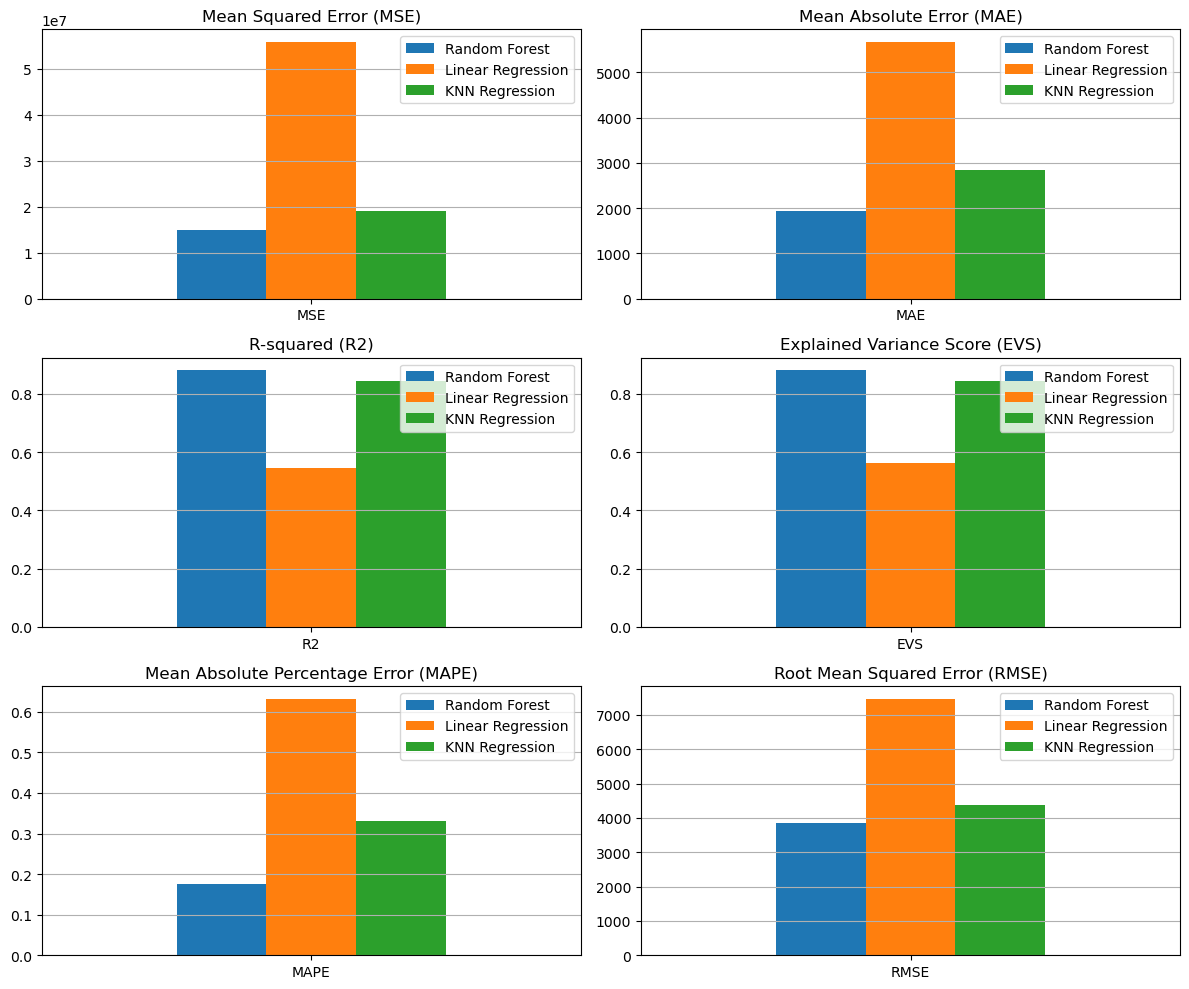

In [20]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse,'KNN Regression': KNN_mse }, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae,'KNN Regression': KNN_mae }, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNN Regression': KNN_r2}, index=['R2'])
df_evs = pd.DataFrame({'Random Forest': RF_evs, 'Linear Regression': LR_evs,'KNN Regression': KNN_evs }, index=['EVS'])
df_mape = pd.DataFrame({'Random Forest': RF_mape, 'Linear Regression': LR_mape,'KNN Regression': KNN_mape }, index=['MAPE'])
df_rmse = pd.DataFrame({'Random Forest': RF_rmse, 'Linear Regression': LR_rmse, 'KNN Regression': KNN_rmse}, index=['RMSE'])


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

df_mse.plot.bar(rot=0, ax=axes[0, 0], legend=True)
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].grid(axis='y')


df_mae.plot.bar(rot=0, ax=axes[0, 1], legend=True)
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].grid(axis='y')


df_r2.plot.bar(rot=0, ax=axes[1, 0], legend=True)
axes[1, 0].set_title('R-squared (R2)')
axes[1, 0].grid(axis='y')


df_evs.plot.bar(rot=0, ax=axes[1, 1], legend=True)
axes[1, 1].set_title('Explained Variance Score (EVS)')
axes[1, 1].grid(axis='y')


df_mape.plot.bar(rot=0, ax=axes[2, 0], legend=True)
axes[2, 0].set_title('Mean Absolute Percentage Error (MAPE)')
axes[2, 0].grid(axis='y')


df_rmse.plot.bar(rot=0, ax=axes[2, 1], legend=True)
axes[2, 1].set_title('Root Mean Squared Error (RMSE)')
axes[2, 1].grid(axis='y')


plt.tight_layout()
plt.show()

# Section 2I Saving Model and Understanding

In [21]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocessor, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

pipe.fit(X, y)
final_model=pipe.fit(X, y)

In [22]:
filename = 'final_modelregression.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [23]:
#Understanding the features and importance

random_forest_importances = RF_best_model.named_steps['ttr'].regressor_.feature_importances_
feature_names = list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out())


for feature, importance in zip(feature_names, random_forest_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: children, Importance: 0.039348969714379546
Feature: bmi, Importance: 0.05644937559895839
Feature: age, Importance: 0.3975608222051901
Feature: OneHot__gender_male, Importance: 0.002027470831048965
Feature: OneHot__region_northwest, Importance: 0.2530647596657454
Feature: OneHot__region_southeast, Importance: 0.25154860198467754


# Section 2J Conclusion and Comments 

In this part of the Etivity I took the data from Part 1, insurance data, and did not create a binary target but left it continous.  The EDA and transformations required involved no imputation and was generally in a good condition so I left it with one hot encoding and minmax scaling.  The insurance cost variable was skewed so it has a log transform on prediction with an inverse log to return results/predictions.

I added in Select K best feature reduction parameters into the dimension reduction which worked but didnt offer the "best model" at any time.  

I used, for the third model the KNN regressor has it had a lot of possible hyparmeters to explore over linear regression (which could rely more on non linear transforms to improve results.

I added in more metrics for evaluation into the evaluation function and displayed the comparisons, in all cases, the Random Forest Predictor was the best performer.  Performance time on the regression models was generally similar so in this case Random Forest would be the chosen model.

The feature importance suggests that age is the largest driver, which makes sense from the EDA, with the Region being important suggesting different pricing in those areas.

# Rubrix Overview

Open a new Jupyter notebook and name it etivity3_regression.ipynb. In this notebook, train three regression pipelines with Random Forest, Linear Regression and a third regressor of your choice as the final estimator, respectively, for predicting the value of `insurance_cost`. __DONE Added K-Nearest Neighbour Regressor__

Requirements:

For each regressor, include data preparation and dimensionality reduction steps in the main pipeline.__DONE__

You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them.
For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.  __DONE KNN Regressor compared to RF and Linear Regression__

Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one.  __DONE__

Summarise your experience in a markdown cell (max 150 words in a markdown cell).  __DONE Above and throughout workbook where appropriate__